# Fashion Product Image Generation

In this project we will present the deep learning generative models that can generate new images of fashion products. 

Main objects of the project: Given an article type and a color the model should be able to generate a corresponding image.

We will use [**TensorFlow**](https://ekababisong.org/gcp-ml-seminar/tensorflow/) framework and [**Keras**](https://keras.io/) open-source library for neural network development


## Useful models import

In [1]:
import tensorflow as tf
from tensorflow import keras
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from scipy import linalg
from keras import layers
from keras import backend as K
import os

## Utility Functions
Execute the following code to define some utility functions used in this project:
- `get_dataset_folder_file_path`: given file name returns its path 
- `get_image_path`: given image id returns its path
- `labels_provider`: given a list with one hot encoded labels and batch size, returns a supplier that gives one batch of data from the list in one iteration.
- `infinite_generator`: used by label infinite lambda provider

In [2]:
DATASET_PATH = "dataset/"

IMG_FOLDER = DATASET_PATH + "subset2/subset/"

def get_dataset_folder_file_path(file_name):
    return DATASET_PATH + file_name

def get_image_path(image_id, folder=IMG_FOLDER):
    return folder + str(image_id) + ".jpg"

def labels_provider(l, n): 
   while len(l) > 0:
      poped = l[:n]
      l = l[n:]
      yield poped

def infinite_generator(value):
    while True:
        yield value

label_provider = lambda a: infinite_generator(a)

### Ploters 
Execute the following code to define the utility functions used for image and chart plotting:
- `plot_images_by_id`: plot images given a list of ids
- `plot_random_images`: plot images given a pandas dataframe
- `plot_generated_images`: plot images given list with image pixels data
- `plot_provided_images`: plot images given a image provider
- `plot_model_input_and_output`: plot input and output images of an autoencoder model
- `plot_same_model_input_and_output`: works as `plot_model_input_and_output` but can take in input always the same batch of images

In [4]:
#ids (list): is a list of image id, the number of ids must be multiple of 5
def plot_images_by_id(ids, folder=IMG_FOLDER):
    rows = int(len(ids)/8)
    fig, axes = plt.subplots(rows, 8, figsize=(8, rows*3))

    for i, ax in enumerate(axes.flatten()):
        image_id = ids[i]
        image_path = get_image_path(image_id, folder)  
        img = Image.open(image_path)
        ax.imshow(img, cmap='Greys_r')
        ax.set_title(image_id)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_random_images(df, num=8, path=IMG_FOLDER):
  """ plot random images from dataframe

  Args:
      df (dataframe): pandas dataframe
      num (int, optional): number of images. Defaults to 15.
      path (string, optional): path to the folder with images. Defaults to paths.IMG_FOLDER.
  """
  ids = df['id']
  selected_image_ids = random.sample(ids.tolist(), num)
  plot_images_by_id(selected_image_ids, path)


def plot_generated_images(generated_images, nrows, ncols, no_space_between_plots=False, figsize=(15, 15)):
  _, axs = plt.subplots(nrows, ncols, figsize=figsize,squeeze=False)

  for i in range(nrows):
    for j in range(ncols):
      axs[i,j].axis('off')
      axs[i,j].imshow(generated_images[i][j], cmap='gray')

  if no_space_between_plots:
    plt.subplots_adjust(wspace=0,hspace=0)

  plt.show()
  
def plot_provided_images(provider):
    it = next(provider)
    if(type(it) is tuple):
       images, _ = it
    else: 
        images = it 

    print("An image shape: ", images[1].shape)
    plot_generated_images([images], 1, 5)

    print("Images shape (numImages, high, width, numColors):")
    print(images.shape)

# Used for showing autoencoder input and its corresponding output
def plot_model_input_and_output(generator, model, num=6):
   # Trasform 5 random images from validation set
   val_x, val_y = next(generator)
   if (len(val_x) < num):
      val_x, val_y = next(generator) # redo 

   # get first 5 dataset images
   real_imgs = val_x[:num] 
   labels = val_y[:num]
   plot_generated_images([real_imgs], 1, num)

   generated_imgs = model.predict([real_imgs,labels], verbose=0)
   plot_generated_images([generated_imgs], 1, num)

def plot_same_model_input_and_output(val_x, val_y, model, num=6):
   real_imgs = val_x[:num] 
   labels = val_y[:num]
   plot_generated_images([real_imgs], 1, num)

   generated_imgs = model.predict([real_imgs,labels], verbose=0)
   plot_generated_images([generated_imgs], 1, num)


#### History ploters
Execute the following code to define the utility functions used for model history loss changes chart plotting:
- `plot_fid`: plot Frechet Inception Distance by checkpoints
- `plot_losses_from_array`: plot trainig and validation losses

In [5]:
def plot_fid(fid_values):
  checkpoints = range(1, len(fid_values) + 1)

  plt.figure(figsize=(10, 6))
  plt.plot(checkpoints, fid_values, marker='o', linestyle='-')
  plt.title('FID Changes by Checkpoint')
  plt.xlabel('Checkpoint')
  plt.ylabel('FID Value')
  plt.grid(True)


def plot_losses_from_array(training_losses, validation_losses):
  epochs = list(range(1, len(training_losses) + 1))
  plt.plot(epochs, training_losses, label='Training Loss',  linestyle='-')
  plt.plot(epochs, validation_losses, label='Validation Loss', linestyle='-')

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')
  plt.legend()

## Dataset
The [**Fashion Product Images (Small)**](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small?select=styles.csv) dataset, containing 80x60 colorful images of fashion products. Original dataset have 44000 products

There are 143 article types half of them have less than 50 articles. We choose 12 the most stable and homogeneous article types as our working target: *Watches*, *Handbags*, *Sunglasses*, *Belts*, *Backpacks*, *Sarees*, *Deodorant*, *Nail Polish*, *Ties*, *Sports Shoes*, *Flip Flops*, *Formal Shoes*. Those 12 classes contains circa 12000 of products.


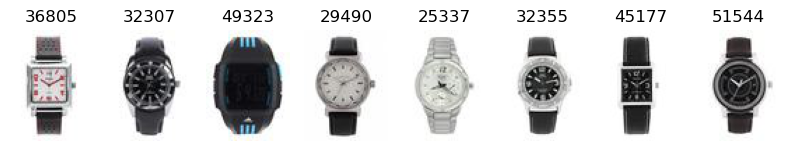

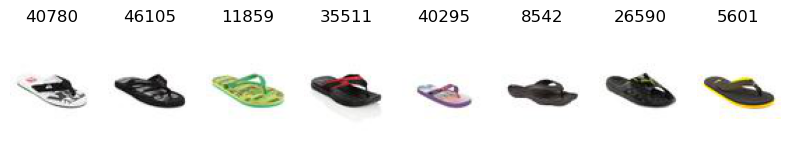

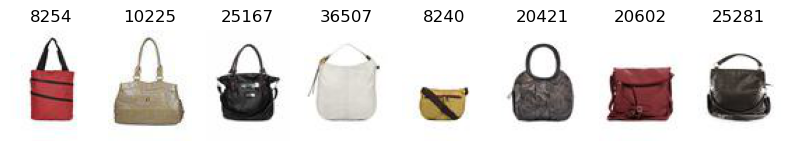

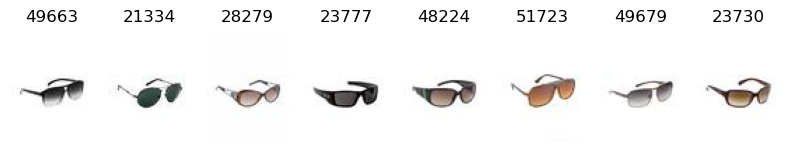

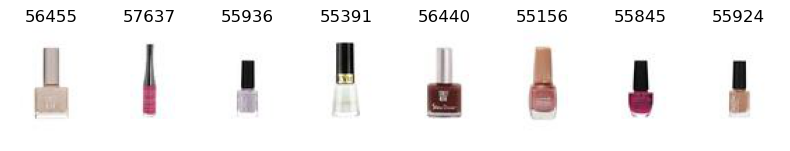

Watches        2516
Handbags       1736
Sunglasses     1073
Flip Flops      904
Nail Polish     329
Name: articleType, dtype: int64

In [7]:
### Possible classes:

# "Watches" 
# "Handbags" 
# "Sunglasses" 
# "Belts" 
# "Backpacks"
# "Sarees" 
# "Deodorant" 
# "Nail Polish" 
# "Ties" 
# "Sports Shoes" 
# "Flip Flops" 
# "Formal Shoes" 

# Flexible list of the article types that will be elaborated by neural networks
CLASSES = ["Watches", "Handbags", "Sunglasses", "Flip Flops", "Nail Polish"]

def filter_articles(df, classes):
    return df[df['articleType'].isin(classes)]

def get_dataframe_by(df, column_name, value):
    return df[df[column_name] == value]

def get_dataframe_by_article_type(df, article_type):
    return get_dataframe_by(df, "articleType", article_type)

def get_dataframe_by_color(df, color):
    return get_dataframe_by(df, "baseColour", color)

def load_df(classes):
    df = pd.read_csv(get_dataset_folder_file_path('styles.csv'), dtype=str)
    df = df[df.notnull()["baseColour"]] # remove null values from basecolor column

    # df['articleType'].value_counts()
    df = filter_articles(df, classes)
    return df

def image_exists(id):
    image_filename = f'{IMG_FOLDER}{id}.jpg'
    return os.path.exists(image_filename)


df = load_df(CLASSES)
df = df[df['id'].apply(image_exists)]

for t in df['articleType'].unique():
    plot_random_images(get_dataframe_by_article_type(df, t))

df['articleType'].value_counts() # number of products for each article type
#todo blacklist


### Color aggregation
In dataset the products have 42 different colors. To be able generate images of a specific color in a stable way we should aggregate similar colors. After aggregation our articles will have 10 colors

before aggreation number of colors:  43
After aggreation number of colors:  10
White


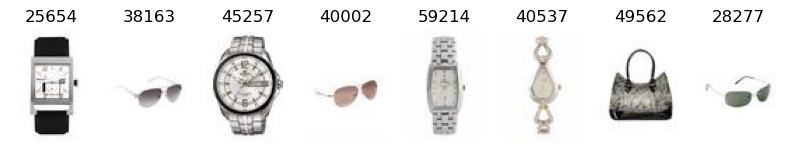

Black


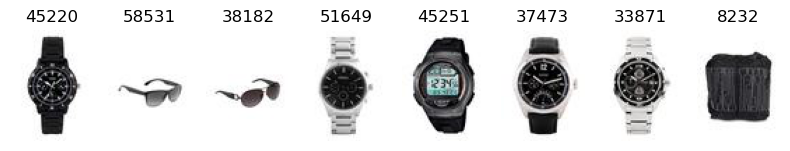

Blue


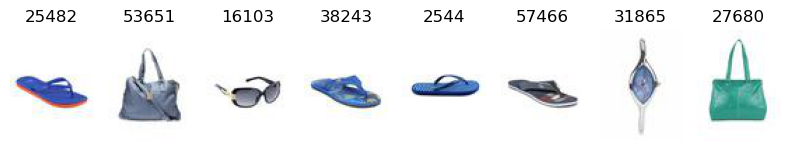

Multi


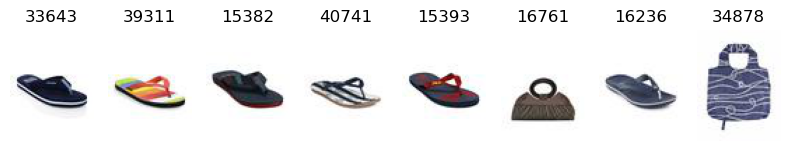

Brown


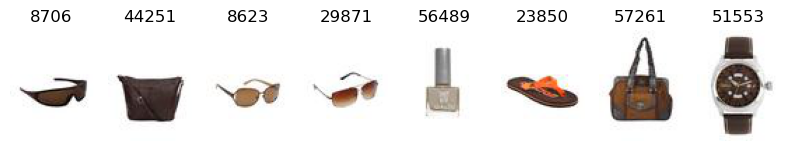

Green


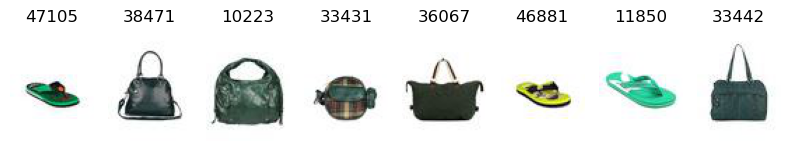

Yellow


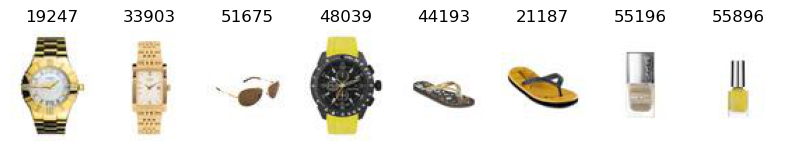

Red


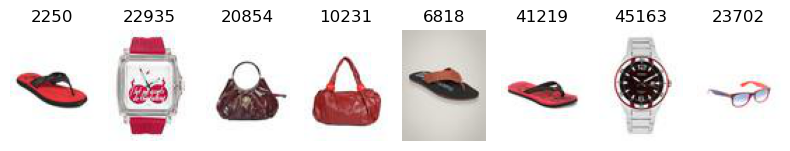

Pink


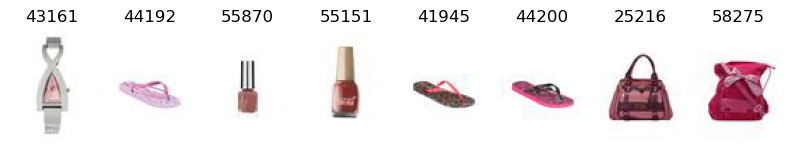

Purple


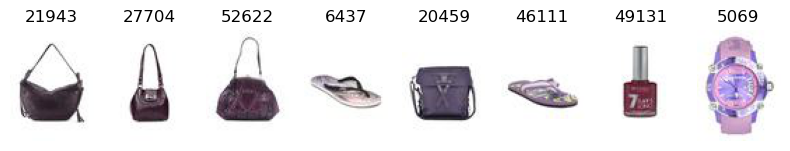

Black     1959
White     1545
Brown      806
Red        475
Blue       422
Pink       340
Yellow     276
Purple     263
Green      241
Multi      231
Name: baseColour, dtype: int64

In [8]:
baseColour = "baseColour"

def aggregate_df_colors(df): 
    print("before aggreation number of colors: ", len(df[baseColour].value_counts()))

    df[baseColour] = df[baseColour].replace("Lime Green", "Green")
    df[baseColour] = df[baseColour].replace("Fluorescent Green", "Green")
    df[baseColour] = df[baseColour].replace("Sea Green", "Green")
    df[baseColour] = df[baseColour].replace("Teal", "Green")

    df[baseColour] = df[baseColour].replace("Taupe", "Grey")
    df[baseColour] = df[baseColour].replace("Grey Melange", "Grey")
    df[baseColour] = df[baseColour].replace("Steel", "Grey")
    df[baseColour] = df[baseColour].replace("Silver", "Grey")
    df[baseColour] = df[baseColour].replace("Skin", "Beige")
    df[baseColour] = df[baseColour].replace("Grey", "White") # White + Grey
    df[baseColour] = df[baseColour].replace("Beige", "White") # White + Beige
    df[baseColour] = df[baseColour].replace("Off White", "White")

    df[baseColour] = df[baseColour].replace("Mushroom Brown", "Brown")
    df[baseColour] = df[baseColour].replace("Nude", "Brown")
    df[baseColour] = df[baseColour].replace("Coffee Brown", "Brown")
    df[baseColour] = df[baseColour].replace("Burgundy", "Brown")
    df[baseColour] = df[baseColour].replace("Copper", "Brown")
    df[baseColour] = df[baseColour].replace("Bronze", "Brown")
    df[baseColour] = df[baseColour].replace("Tan", "Brown")
    df[baseColour] = df[baseColour].replace("Khaki", "Brown")

    df[baseColour] = df[baseColour].replace("Rose", "Red")
    df[baseColour] = df[baseColour].replace("Orange", "Red")
    df[baseColour] = df[baseColour].replace("Rust", "Red")
    df[baseColour] = df[baseColour].replace("Maroon", "Red")

    df[baseColour] = df[baseColour].replace("Magenta", "Pink")
    df[baseColour] = df[baseColour].replace("Peach", "Pink")

    df[baseColour] = df[baseColour].replace("Mauve", "Purple")
    df[baseColour] = df[baseColour].replace("Lavender", "Purple")

    df[baseColour] = df[baseColour].replace("Metallic", "Black")
    df[baseColour] = df[baseColour].replace("Charcoal", "Black")

    df[baseColour] = df[baseColour].replace("Turquoise Blue", "Blue")

    df[baseColour] = df[baseColour].replace("Mustard", "Yellow")
    df[baseColour] = df[baseColour].replace("Gold", "Yellow")

    df[baseColour] = df[baseColour].replace("Cream", "Multi")
    df[baseColour] = df[baseColour].replace("Olive", "Multi")
    df[baseColour] = df[baseColour].replace("Navy Blue", "Multi")
    return df

def get_df():
    df = load_df(CLASSES)
    df = df[df['id'].apply(image_exists)]
    df = aggregate_df_colors(df)
    return df

df = get_df()
print("After aggreation number of colors: ", len(df[baseColour].value_counts()))

for color in df[baseColour].unique():
    print(color)
    plot_random_images(get_dataframe_by_color(df, color))

df[baseColour].value_counts() # number of products for each color

### Dataset loading and preprocessing
`MultiLabelImageDataGenerator` is an adapter to a [`DataFrameIterator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe) that allow to normalize the outputs of "categorical" and "multi_label" setups. 
The output of *DataFrameIterator* is:
- In case of **`categorical`** single label configuration it is a tuple where first element is array of images and second array of **one hot encoded** labels
    - Example: `([img_1, img_2], [one_hot_1, one_hot_2])`
- In case of **`multi_label`**  class mode configuration it is a tuple where first element is array of images but the second element is an array that containst multiple arrays each of them contains all labels in **string format**. So the one hot encoding should be implemented additionally.
    - Example `([img_1, img_2], [["type_1", "type_2"], ["color_1", "color_2"]])`
  
`MultiLabelImageDataGenerator` aims to hide the process of one hot encoding and concatenation of multiple one hot encoding labels (this allows to use the same network for different number of labels). As the result we obtain the same output format for "categorical" and "mutiple_label" configurations

In [9]:
class MultiLabelImageDataGenerator:
    def __init__(self, generator, articleType_encoder, color_encoder):
        self.generator = generator
        self.articleType_encoder = articleType_encoder
        self.color_encoder = color_encoder
        self.articl_n_classes =  len(articleType_encoder.classes_)
        self.color_n_classes =  len(color_encoder.classes_)
        self.num_classes = self.articl_n_classes + self.color_n_classes 
        self.class_indicies = articleType_encoder.classes_

        all_artcle = to_categorical(articleType_encoder.transform(generator.labels[0]))
        all_colors = to_categorical(color_encoder.transform(generator.labels[1]))

        concatenated = []
        for i in range(len(all_artcle)):
            concatenated.append(all_artcle[i].tolist() + all_colors[i].tolist())
        
        self.labels = np.array(concatenated, dtype=np.float32)

    def __iter__(self):
        return self
    
    def __next__(self):
        x, y = next(self.generator)
        articleType_one_hot = to_categorical(self.articleType_encoder.transform(y[0]), num_classes=self.articl_n_classes)
        color_one_hot = to_categorical(self.color_encoder.transform(y[1]), num_classes=self.color_n_classes)
        concatenated = []
        for i in range(len(articleType_one_hot)):
            concatenated.append(articleType_one_hot[i].tolist() + color_one_hot[i].tolist())
        
        return x, np.array(concatenated, dtype=np.float32)
    
    def __len__(self):
        return len(self.generator)
    

#### Data provider definition
Data provider is based on [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) that use a flow from dataframe that allows flexible loading of images from directory.
- `create_data_provider_df`: create a new provider of dataset images
    - Args:
      - `data_dir` (string): path to the directory with images
      - `classes` (list of strings): list with article types that should be uploaded 
      - `class_mode` (str):
        - "categorical" if one hot encoded label should contain only articleType.
        - "multi_output" if one hot encoded label should contain articleType and baseColour.
      - `batch_size` (int, optional): Number of images uploaded at each iteration. Defaults to 64.
      - `image_size` (tuple, optional): image size. Defaults to (80,60).
      - `rgb` (bool, optional): true if images should be with colors. Default is False.
      - `tanh_rescale` (bool, optional): rescale image values from -1 to 1. Default is False
      - `validation_split` (flaot, optional): define what part of data split to validation data. Default is 0.1
    - Returns:
      - `MultiLabelImageDataGenerator`: for "multi_output"  `class_mode`
      - `DataFrameIterator`: for "categorical" and others `class_mode`

In [10]:
def create_data_provider_df(
        data_dir, 
        class_mode,
        batch_size=64, 
        image_size = (80,60), 
        rgb=False,
        tanh_rescale=False,
        validation_split = 0.1):
    color_mode =  "rgb" if (rgb) else "grayscale" 
    y = ["articleType", "baseColour"] if(class_mode=="multi_output") else "articleType"

    df = get_df()
    def append_ext(id): return id+".jpg"
    df['id'] = df['id'].apply(append_ext)
    
    articleType_encoder = LabelEncoder()
    color_encoder = LabelEncoder()
    articleType_encoder.fit(df["articleType"].unique())
    color_encoder.fit(df["baseColour"].unique())

    datagen = ImageDataGenerator(
        validation_split=validation_split,
    ) 

    if(tanh_rescale):
        def prep_fn(img):
            img = img.astype(np.float32) / 255.0
            img = (img - 0.5) * 2
            return img
        datagen.preprocessing_function = prep_fn
    else:
        datagen.rescale = 1.0 / 255.0,  # Scale pixel values between 0 and 1

    train_data_provider = datagen.flow_from_dataframe(
        df,
        data_dir,
        x_col="id",
        y_col=y,
        color_mode=color_mode,
        target_size=image_size,
        batch_size=batch_size,
        class_mode=class_mode,#'input', 'categorical' 
        shuffle=True, 
        subset='training'
    )

    val_data_provider = datagen.flow_from_dataframe(
        df,
        data_dir,
        x_col="id",
        y_col=y,
        color_mode=color_mode,
        target_size=image_size,
        batch_size=batch_size,
        class_mode=class_mode,#'input', 'categorical' 
        shuffle=True,
        subset='validation'
    )
    if(class_mode=="multi_output"):
        train_data_provider = MultiLabelImageDataGenerator(train_data_provider, articleType_encoder, color_encoder)
        val_data_provider = MultiLabelImageDataGenerator(val_data_provider, articleType_encoder, color_encoder)
    
    return train_data_provider, val_data_provider

#### Data provider creation

We have several configurable variables for dataset provider personalizzation:
- `BATCH_SIZE` difine how many images will be provided in one iteration
- `image_heigh` and `image_weigh` defines the size of images
- `num_color_dimensions` 1 for greyscale or 3 for RGB images
- `with_color_label` if true the one hot encoded label contains together article type and color information

before aggreation number of colors:  43
Found 5903 validated image filenames.
Found 655 validated image filenames.
An image shape:  (80, 80, 3)


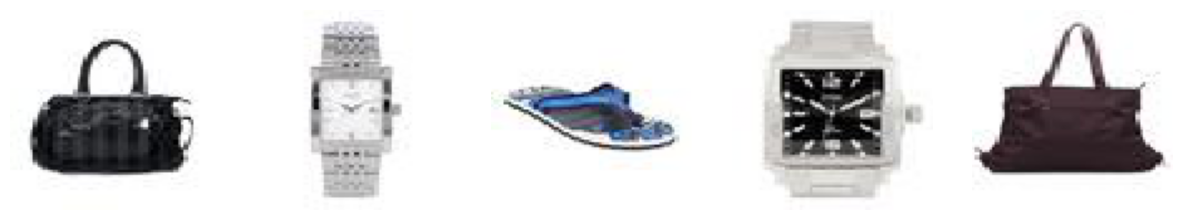

Images shape (numImages, high, width, numColors):
(64, 80, 80, 3)


In [11]:
BATCH_SIZE = 64
image_heigh = 80
image_weigh = 80
num_color_dimensions = 3 # 1 for greyscale or 3 for RGB
with_color_label = True # class label inlude article color

# Computed parameters
image_size = (image_heigh, image_weigh)
image_shape = (image_heigh, image_weigh, num_color_dimensions)
num_pixels = image_heigh * image_weigh * num_color_dimensions
rgb_on = (num_color_dimensions==3)
is_fid_active = image_heigh == image_weigh and image_weigh > 75 and rgb_on #check FID constrains
if(with_color_label and (not rgb_on)): # error check
   raise Exception("Illegal state: color label can be used only with RGB images")

class_mode = "multi_output" if(with_color_label) else "categorical"
train_provider, val_provider  = create_data_provider_df(
    IMG_FOLDER,
    class_mode=class_mode,
    image_size=image_size,
    batch_size=BATCH_SIZE,
    rgb=rgb_on,
)
one_hot_label_len = train_provider.num_classes if(with_color_label) else len(train_provider.class_indices)
if(type(train_provider) is MultiLabelImageDataGenerator):
    all_one_hot_labels = train_provider.labels
else:
    all_one_hot_labels = to_categorical(train_provider.labels)

plot_provided_images(train_provider)

## Frechet Inception Distance (FID)
As main metric for evalution image quality we choose [**Frechet Inception Distance (FID)**](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance). 

FID compares the distribution of generated images with the distribution of real images. The first step involves calculating the feature vector of each image in each domain using the [InceptionNet v3](https://keras.io/api/applications/inceptionv3/) model. FID compares the mean and standard deviation of the gaussian distributions containing feature vectors obtained from the deepest layer in Inception v3.

The final formula is
$$d^2=||μ_1−μ_2||^2+Tr(C_1+C_2−2\sqrt{C_1⋅C_2})$$
Where:
- The “$\mu_1$” and “$\mu_2$” refer to the feature-wise mean of the real and generated images, e.g. 2,048 element vectors where each element is the mean feature observed across the images.
- The *$C_1$* and *$C_2$* are the covariance matrix for the real and generated feature vectors.
- The *$||\mu_1 – \mu_2||^2$* refers to the sum squared difference between the two mean vectors. 
- *$Tr$* refers to the [trace linear algebra operation](https://en.wikipedia.org/wiki/Trace_(linear_algebra)?ref=blog.paperspace.com), e.g. the sum of the elements along the main diagonal of the square matrix.
  
Practical use of FID have some limitation because `InceptionV3` model accepts only square colorful images bigger than 75x75

In [12]:
def getInceptionModel(image_shape):
    inception_model = tf.keras.applications.InceptionV3(include_top=False, 
                                input_shape=image_shape,
                                weights="imagenet", 
                                pooling='avg')
    return inception_model

def compute_embeddings(dataloader, count, inception_model):
    image_embeddings = []
    it = iter(dataloader)
    for _ in range(count):
        images = next(it)
        if(type(images) is tuple):
            images, _ = images
        embeddings = inception_model.predict(images, verbose=0)
        image_embeddings.extend(embeddings)
    return np.array(image_embeddings)

def calculate_fid(real_embeddings, generated_embeddings):
    # calculate mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return round(math.sqrt(fid),2)

def compute_fid(real_img_generator, fake_img_generator, image_shape):
    count = len(real_img_generator) - 1

    inception_model = getInceptionModel(image_shape)

    # compute embeddings for real images
    real_image_embeddings = compute_embeddings(real_img_generator, count, inception_model)

    # compute embeddings for generated images
    generated_image_embeddings= compute_embeddings(fake_img_generator, count, inception_model)

    if(len(generated_image_embeddings) > len(real_image_embeddings)):
        #make two arrays equal
        generated_image_embeddings = generated_image_embeddings[:len(real_image_embeddings)]

    fid = calculate_fid(real_image_embeddings, generated_image_embeddings)
    print("FID: " + str(fid))
    return fid
 

### Autoencoder Image Generator
For FID calculation we need to wrap our image gerator model into an iterator, it allows produce new generated images without specifing model inputs. `CCVAEImageGenerator` is also useful for image plotting.

In [13]:
normal_variate_sigma = 0.7 # change generation image variation lavel

class CCVAEImageGenerator:
    def __init__(self, model, label_provider):
        self.model = model
        self.encoder_input_size = model.layers[0].input_shape[0][1]
        self.label_provider = label_provider

    def __iter__(self):
        return self
    
    def __next__(self):
        inputs = []
        labels = next(self.label_provider)
        for _ in range(len(labels)):
            random_sample = []
            for _ in range(self.encoder_input_size):
                random_sample.append(random.normalvariate(0, normal_variate_sigma))
            inputs.append(random_sample)
        generated_images = self.model.predict([np.array(inputs), np.array(labels)], verbose=0)
        
        return generated_images

# Autoencoder
As architecture for this problem resolution was choosen Convulutional Conditional Variational Autoencoder (CCVAE)
![Alt text](image.png)

## Model definition

In [14]:
from tensorflow import keras
from keras import layers
from keras import backend as K

class CCVAE():
    def __init__(self):
       self.num_downsampling = 3

    def build_ccvae(self, shape, dense_neurons, encoded_dim, hidden_activation, label_input_len):
        #Input
        encoder_input = layers.Input(shape=shape, name='encoder_img_input')
        label_input = layers.Input(shape=(label_input_len,), name='encoder_label_input')
        encoder_label = layers.Dense(shape[0]*shape[1], name="encoder_label_size_augmentation")(label_input)
        encoder_label = layers.Reshape((shape[0], shape[1], 1), name="encoder_label_reshape")(encoder_label)
        concatedated_input = layers.Concatenate(name="input_concatenator")([encoder_input, encoder_label])

        #Encoder
        prev_layer, last_conv_shape = self.build_encoder(concatedated_input, hidden_activation, dense_neurons)
        
        mu = layers.Dense(encoded_dim, name='mu')(prev_layer)
        log_var = layers.Dense(encoded_dim, name='log_var')(prev_layer)

        encoder = keras.Model([encoder_input, label_input], [mu, log_var], name='encoder')

        #Decoder
        decoder_input = layers.Input(shape=(encoded_dim,), name='decoder_input')
        concatedated_input_dec = layers.Concatenate(name="decoder_concat_input")([decoder_input, label_input])

        prev_layer = self.build_decoder(concatedated_input_dec, hidden_activation, dense_neurons, last_conv_shape)
        decoder_output_layer = layers.Conv2D(shape[2], 4, padding="same", activation='sigmoid')(prev_layer)

        decoder = keras.Model([decoder_input, label_input], decoder_output_layer, name='decoder')

        #Sampling layer
        s = layers.Lambda(self.sampling, output_shape=(encoded_dim,), name='s')([mu, log_var])

        #VAE
        vae=keras.Model(encoder.input, decoder([s, label_input]),name='ccvae')

        return vae,encoder,decoder
    
    def build_encoder(self, input, h_activation, dense_neurons):
        prev_layer = input
        channels = 32
        prev_layer = self.create_conv_block(prev_layer, channels, h_activation, 4, norm=True)
        for i in range(self.num_downsampling):
            channels *= 2 
            prev_layer = self.create_downsampling_conv_block(prev_layer, channels, h_activation)
        
        channels = channels/4
        prev_layer = self.create_conv_block(prev_layer, channels, h_activation, 1, norm=True)

        channels *= 2 
        prev_layer = self.create_downsampling_conv_block(prev_layer, channels, h_activation)

        last_conv_shape = K.int_shape(prev_layer)

        prev_layer = layers.Flatten(name="Flatten")(prev_layer)
        
        for neuron_count in dense_neurons:
            prev_layer=layers.Dense(neuron_count,activation=h_activation)(prev_layer)
        
        return prev_layer, last_conv_shape
        

    def build_decoder(self, input, h_activation, dense_neurons, last_conv_shape):
        prev_layer=input
        for neuron_count in reversed(dense_neurons):
            prev_layer=layers.Dense(neuron_count,activation=h_activation)(prev_layer)
    
        n = last_conv_shape[1] * last_conv_shape[2] * last_conv_shape[3]
        prev_layer = layers.Dense(n, activation=h_activation)(prev_layer)
        prev_layer = layers.Reshape((last_conv_shape[1],last_conv_shape[2], last_conv_shape[3]))(prev_layer)
        channels = last_conv_shape[3]

        for i in range(self.num_downsampling):
            channels //= 2 
            prev_layer = self.create_upsampling_conv_block(prev_layer, channels, h_activation)
            
        channels = channels*4
        prev_layer = self.create_conv_block(prev_layer, channels,h_activation, 1, norm=True)

        channels //= 2 
        prev_layer = self.create_upsampling_conv_block(prev_layer, channels, h_activation)
        return prev_layer

       
    def create_conv_block(self, prev_layer, channels, activation, kernel_size=3, padding='same', norm=False):
      prev_layer = layers.Conv2D(channels, kernel_size, padding=padding, use_bias=True)(prev_layer)
      if(norm):
          prev_layer = layers.BatchNormalization()(prev_layer)
      prev_layer = layers.Activation(activation)(prev_layer) 
      return prev_layer

    def create_downsampling_conv_block(self, prev_layer, channels, activation, kernel_size=3):
        prev_layer = layers.ZeroPadding2D()(prev_layer)
        prev_layer = layers.Conv2D(channels, kernel_size, strides=2, use_bias=False)(prev_layer)
        prev_layer = layers.BatchNormalization()(prev_layer)
        prev_layer = layers.Activation(activation)(prev_layer)  
        return prev_layer

    def create_upsampling_conv_block(self, prev_layer, channels, activation, kernel_size = 3):
        prev_layer = layers.Conv2DTranspose(channels, kernel_size,strides=2, padding="same")(prev_layer)
        prev_layer = layers.BatchNormalization()(prev_layer)
        prev_layer = layers.Activation(activation)(prev_layer) 
        return prev_layer

    def sampling(self, args):
      mu, log_var = args
      batch_size = K.shape(mu)[0]
      dim = K.int_shape(mu)[1]
      epsilon = K.random_normal(shape=(batch_size, dim), mean=0., stddev=1.0)
      return K.exp(0.5 * log_var) * epsilon + mu
    

def vae_loss(vae_input,vae_ouput,mu,log_var,kl_coefficient, input_count):
  #Reconstruction loss
  vae_input = vae_input[0] if(type(vae_input) is list) else vae_input
  x = keras.layers.Reshape((input_count,))(vae_input)
  y = keras.layers.Reshape((input_count,))(vae_ouput)
  reconstruction_loss = keras.losses.mean_squared_error(x, y) * input_count

  #Regularization loss
  kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)

  #Combined loss
  return reconstruction_loss + kl_coefficient*kl_loss

### Model creation

In [15]:
latent_space_dimension = 32
internal_dense_layers = [2048, 512]
vae, vae_encoder, vae_decoder = CCVAE().build_ccvae(
   image_shape, 
   internal_dense_layers, 
   latent_space_dimension,
   'LeakyReLU',
   one_hot_label_len)

vae.summary()

Model: "ccvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_label_input (InputLaye  [(None, 15)]        0           []                               
 r)                                                                                               
                                                                                                  
 encoder_label_size_augmentatio  (None, 6400)        102400      ['encoder_label_input[0][0]']    
 n (Dense)                                                                                        
                                                                                                  
 encoder_img_input (InputLayer)  [(None, 80, 80, 3)]  0          []                               
                                                                                              

### Model visualization

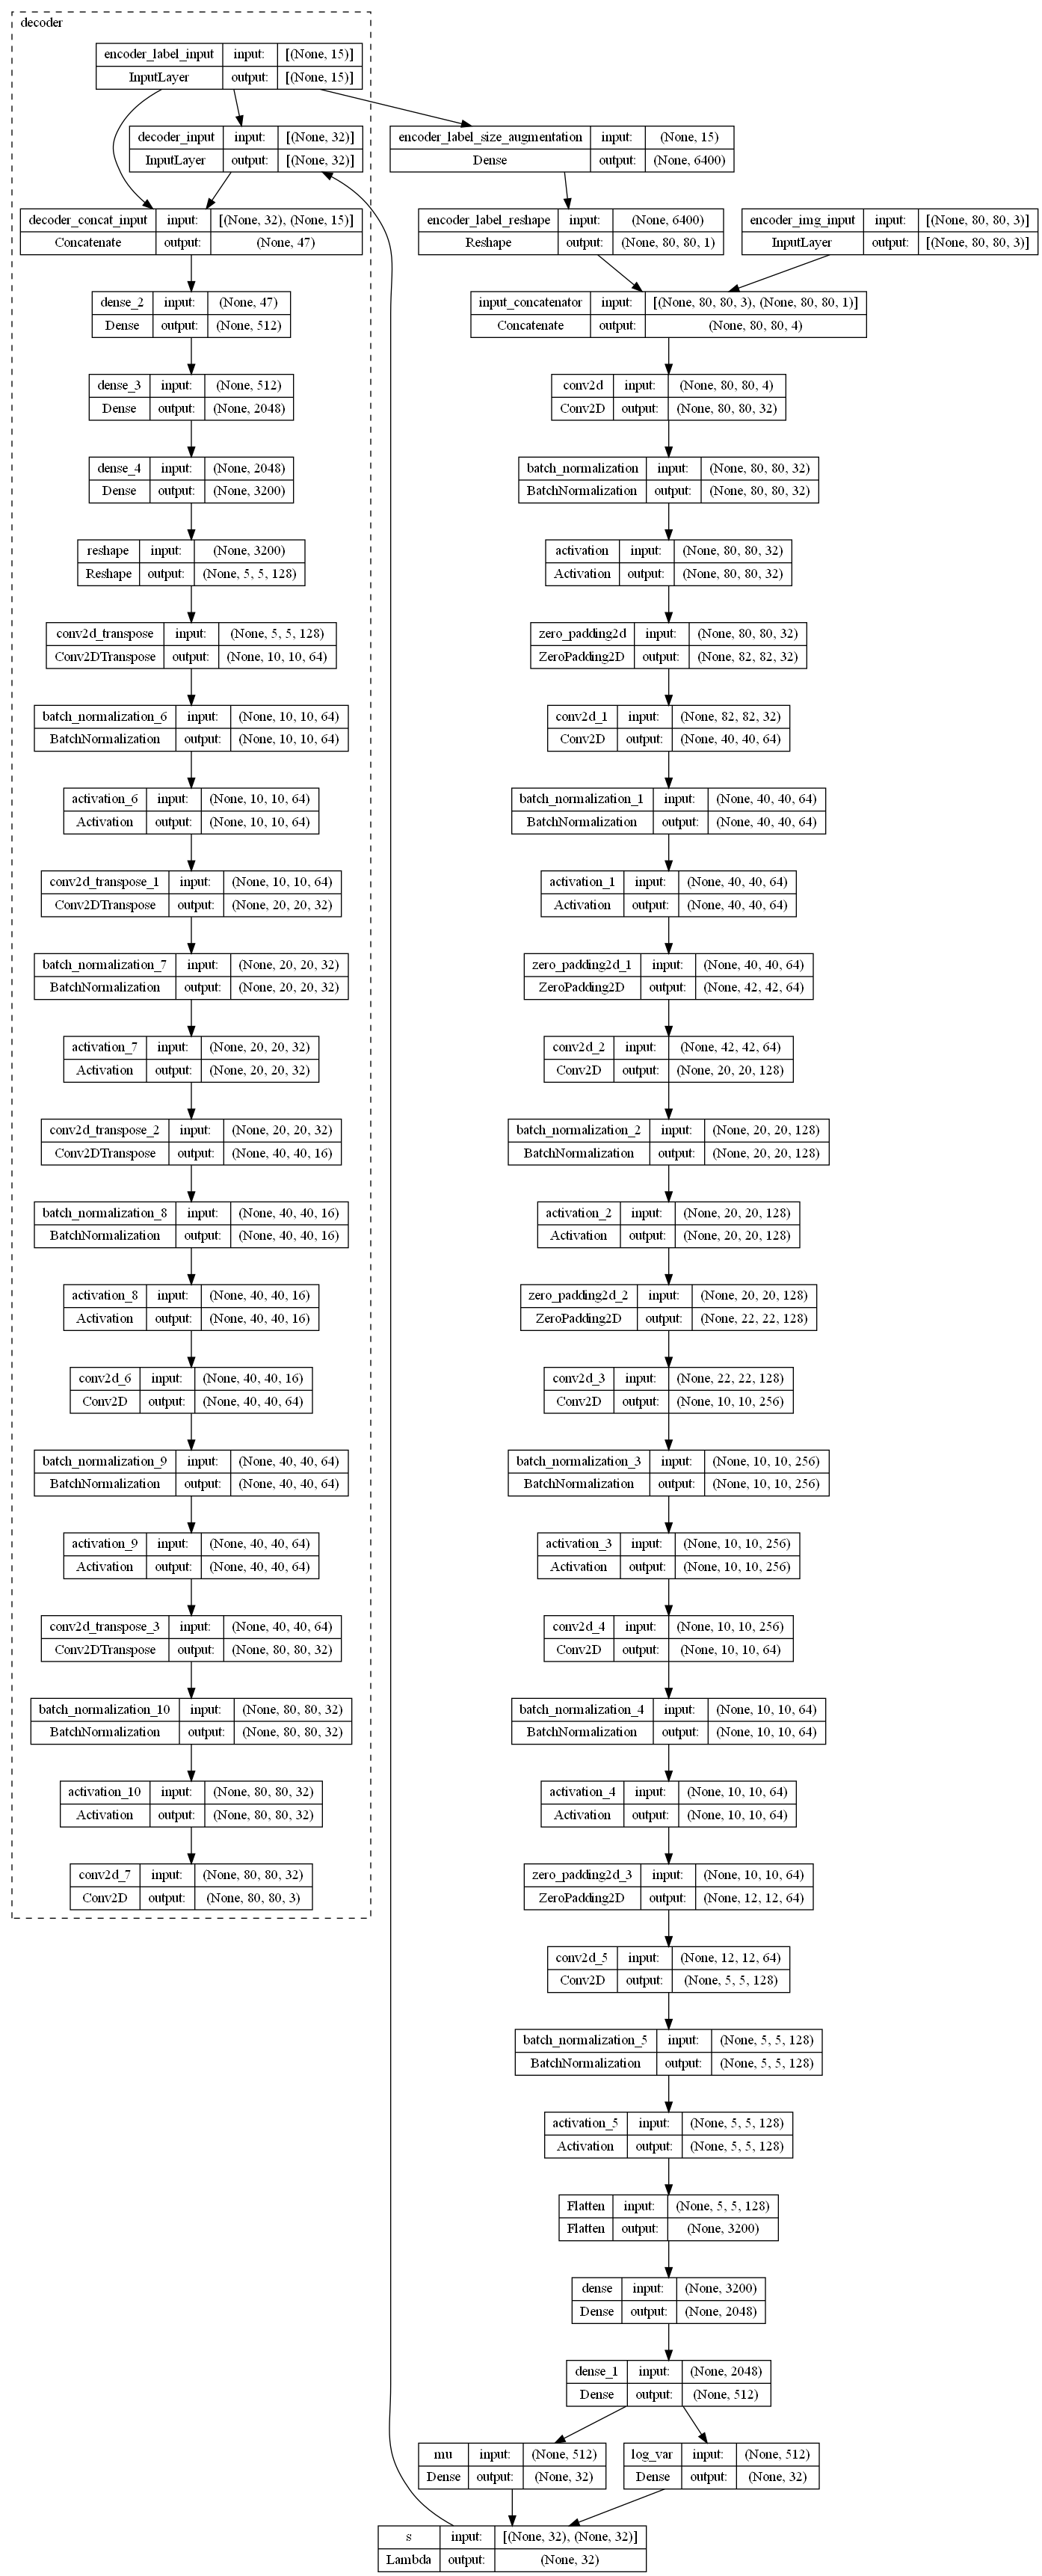

In [16]:
keras.utils.plot_model(vae, show_shapes=True, show_layer_names=True, expand_nested=True)

## Model compilation

In [17]:
### Compilation
kl_coefficient=1

#Information needed to compute the loss function
vae_input=vae.input
vae_output=vae.output
mu=vae.get_layer('mu').output
log_var=vae.get_layer('log_var').output

vae.add_loss(vae_loss(vae_input, vae_output, mu, log_var, kl_coefficient, num_pixels))
vae.compile(optimizer=tf.keras.optimizers.Adam(clipnorm=0.001)) 

loss_metrics=[]
val_loss_metrics=[]
fid_frequency_metrics = []

# Get a batch from validation set for ploting model generalization capabilities
NUM_IMAGES_TO_PLOT = 15
if(NUM_IMAGES_TO_PLOT > BATCH_SIZE):
   raise Exception("Can not plot more images than there are in a batch")
val_x, val_y = next(val_provider)
if (len(val_x) < NUM_IMAGES_TO_PLOT):
   val_x, val_y = next(val_provider) # redo 

## Training

Epoch: 1 exec_time=18.7s  loss=256.550 val_loss=321.760
Epoch: 2 exec_time=18.3s  loss=245.418 val_loss=346.104


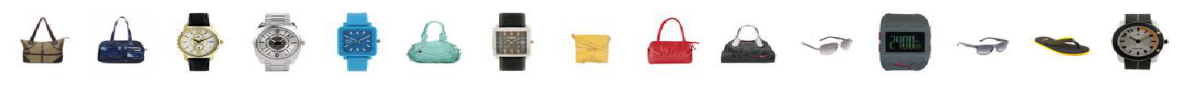

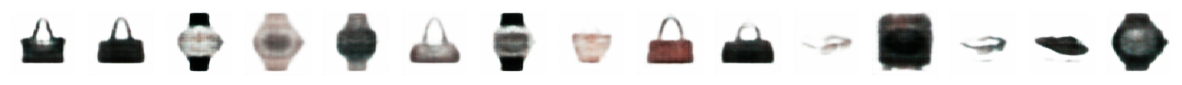

Epoch: 3 exec_time=18.3s  loss=242.793 val_loss=272.063
Epoch: 4 exec_time=18.4s  loss=230.326 val_loss=354.119


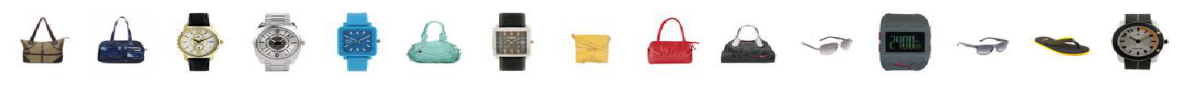

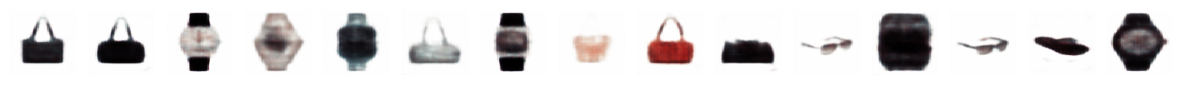

Epoch: 5 exec_time=18.3s  loss=222.976 val_loss=341.012
Epoch: 6 exec_time=18.4s  loss=218.837 val_loss=254.690


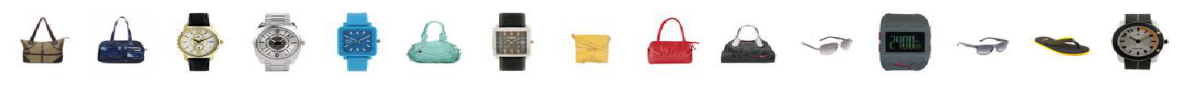

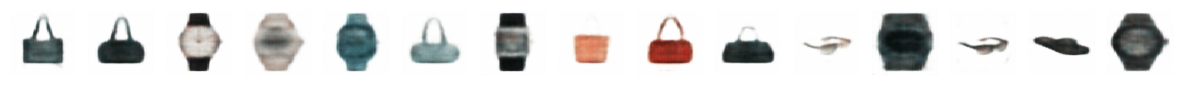

Epoch: 7 exec_time=18.3s  loss=211.685 val_loss=257.081
Epoch: 8 exec_time=18.6s  loss=207.882 val_loss=233.954


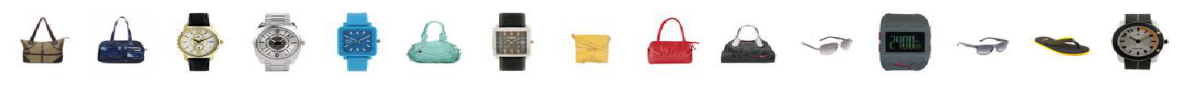

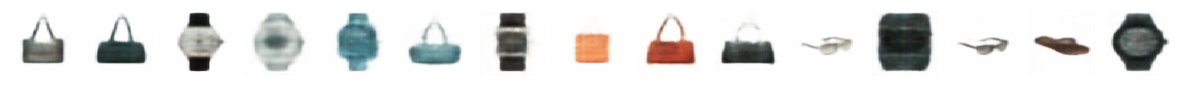

FID: 28.43


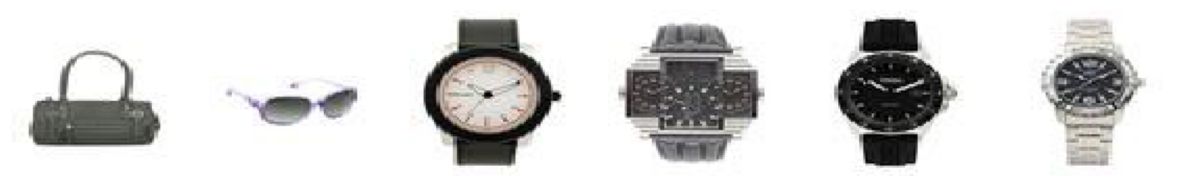

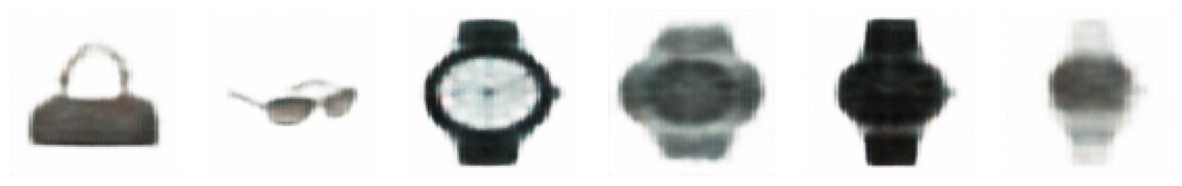

In [23]:
epoch_count = 8
image_plot_frequency = 2 # how often input-output comparation should be ploted
fid_frequency = 8 # how often fid should be calculated

def batch_eleboration(model, generator, validation=False):
   n = 0
   loss_sum = 0
   for _ in range(len(generator)):
      batch_x, batch_y = next(generator)
      if(validation):
         loss = model.test_on_batch([batch_x, batch_y], batch_x)
      else:
         loss = model.train_on_batch([batch_x, batch_y], batch_x)
      n += len(batch_x)
      loss_sum += (loss*len(batch_x))
   return loss_sum / n

for e in range(1, epoch_count+1):
   start_time = time.time()

   loss = batch_eleboration(vae, train_provider)
   loss_metrics.append(loss)

   val_loss = batch_eleboration(vae, val_provider, validation=True)
   val_loss_metrics.append(val_loss)
   
   end_time = time.time()
   print('Epoch: {0} exec_time={1:.1f}s  loss={2:.3f} val_loss={3:.3f}'.format(e,end_time - start_time, loss, val_loss))

   if(e%image_plot_frequency == 0):
      plot_same_model_input_and_output(val_x, val_y, vae, num=NUM_IMAGES_TO_PLOT) 
      #plot_model_input_and_output(val_provider, vae) 
   if(is_fid_active and e%fid_frequency == 0):
      image_generator = CCVAEImageGenerator(vae_decoder, labels_provider(all_one_hot_labels, BATCH_SIZE))
      fid_frequency_metrics.append(compute_fid(train_provider, image_generator, image_shape))

plot_model_input_and_output(val_provider, vae)



## Performance evaluation

For each real label generate one fake img: stddev 4.5

Another solution that generate random colors and  and article types have 25-60 standard deviation



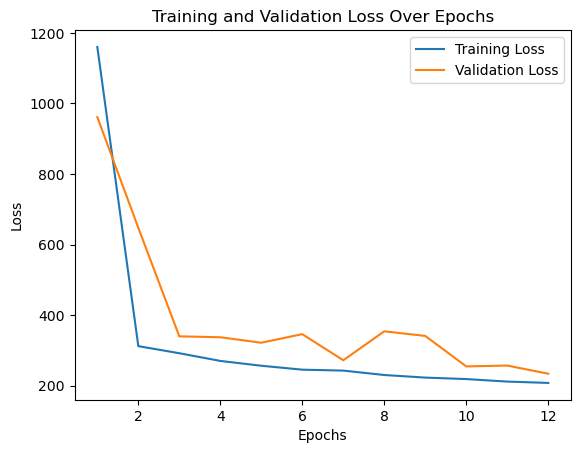

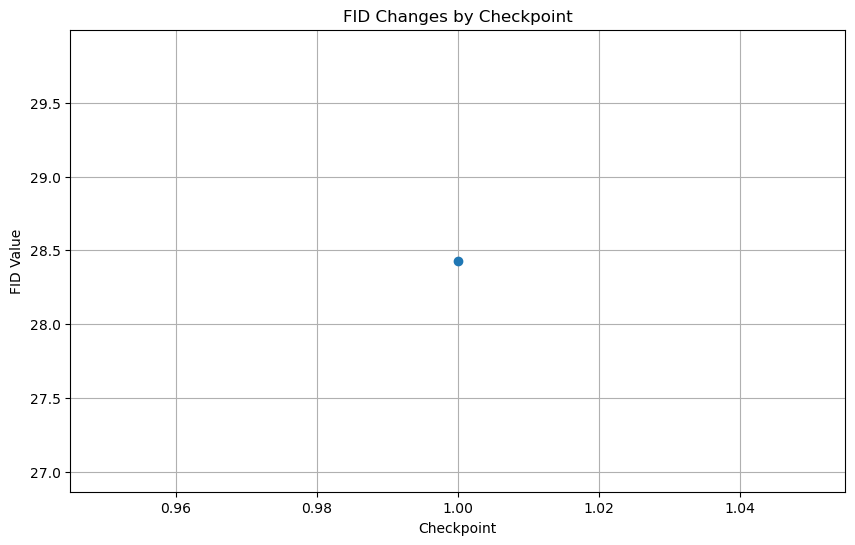

In [24]:
plot_losses_from_array(loss_metrics,val_loss_metrics)

if(is_fid_active):
   plot_fid(fid_frequency_metrics)

## Generated images

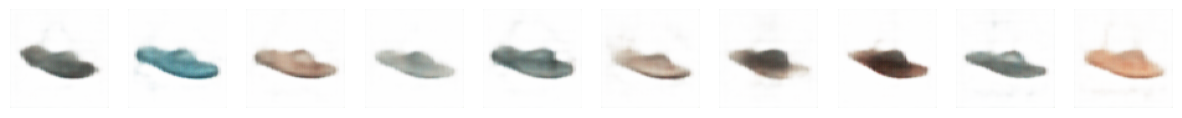

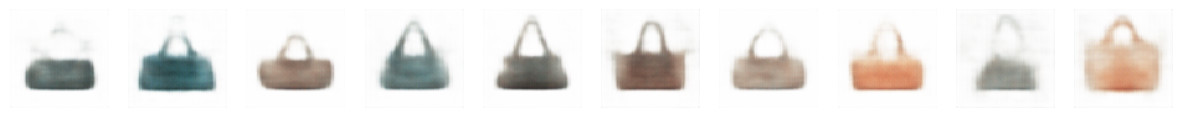

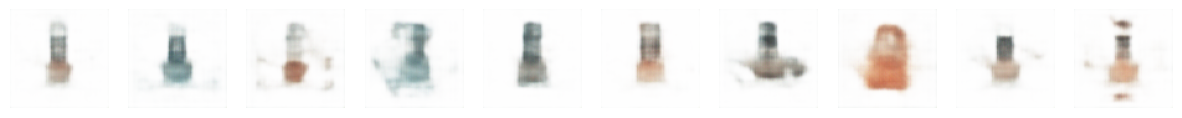

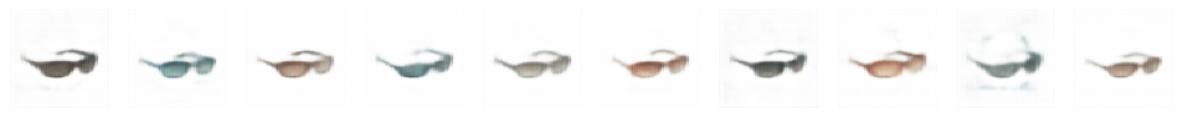

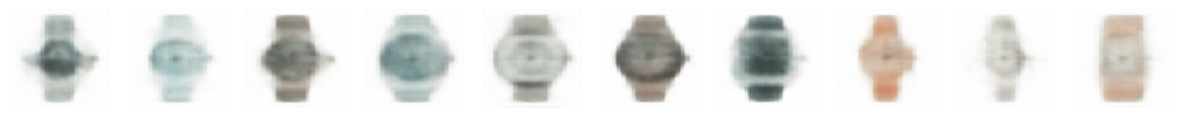

In [29]:

def plot_model_generated_article_types(model, one_hot_len, rows=1, cols=5, imgProducer=CCVAEImageGenerator):
  for i in range(one_hot_len):
    one_hot = np.zeros(one_hot_len, dtype=float)
    one_hot[i] = 1
    one_hots = [one_hot] * cols
    decoderGen = imgProducer(model, label_provider(one_hots))
    iterator = iter(decoderGen)

    generated_images=[]
    for _ in range(rows):
        generated_images.append(next(iterator))      

    plot_generated_images(generated_images,rows,cols)

def plot_model_generated_colorfull_article_types(model, num_classes, one_hot_len, rows=1, imgProducer=CCVAEImageGenerator):
  num_colors = one_hot_len - num_classes
  for clas in range(num_classes):
    one_hots = []
    for color in range(num_classes, one_hot_len):
        one_hot = np.zeros(one_hot_len, dtype=float)
        one_hot[clas] = 1
        one_hot[color] = 1
        one_hots.append(one_hot)
    decoderGen = imgProducer(model, label_provider(one_hots))

    for _ in range(rows):
      plot_generated_images([next(iter(decoderGen))],1,num_colors)

if(with_color_label):
  plot_model_generated_colorfull_article_types(vae_decoder, len(CLASSES), one_hot_label_len, rows=1)
else:
  plot_model_generated_article_types(vae_decoder, one_hot_label_len, rows=1, cols=10)

# Generative adversarial network (GAN)

## Model definition

### Model creation

### Model visualization

## Model compilation

## Training

## Performance evaluation


## Generated images